<div align="right" style="text-align: right"><i>Adopted from Peter Norvig<br></i></div>

# Making and Solving Mazes

Let's make some mazes! I'm thinking of mazes like this one, which is  a rectangular grid of squares, with walls on some of the sides of squares, and openings on other sides. The goal is to get from the red arrow to the green arrow.

![Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Maze_simple.svg/475px-Maze_simple.svg.png)

The two main constraints are that there should be a path from entrance to exit, and it should be ***fun*** to solve the maze with pencil, paper, and brain power&mdash;not too easy, but also not impossible.  

As I think about how to model a maze on the computer, it seems like a **graph** is the right model: the nodes of
the graph are the squares of the grid, and the edges of the graph are the openings between adjacent squares. So what properties of a graph make a good maze?
- There must be a path from entrance to exit.
- There must not be too many such paths; maybe it is best if there is only one.
- Probably the graph should be *singly connected*&mdash;there shouldn't be islands of squares that are unreachable from the start. In fact, maybe we want exactly one path between any two squares.
- The path should have many twists; it would be too easy if it was mostly straight.

I know that a **tree** has all these properties except the last one. So my goal has become: *Superimpose a tree over the grid, covering every square, and make sure the paths are twisty.* Here's how I'll do it:

- Start with a grid with no edges (every square is surrounded by walls on all sides).
- Add edges (that is, knock down walls) for the entrance at upper left and exit at lower right.
- Place the root of the tree in some square.
- Then repeat until the tree covers the whole grid:
  * Select some node already in the tree.
  * Randomly select a neighbor that hasn't been added to the tree yet.
  * Add an edge (knock down the wall) from the node to the neighbor.
  
In the example below, the root, `A`, has been placed in the upper-left corner, and  two branches,
`A-B-C-D` and `A-b-c-d`, have been randomly chosen (well, not actually random; they are starting to create the same maze as in the diagram above):

     o  o--o--o--o--o--o--o--o--o--o
     | A  b  c|  |  |  |  |  |  |  |
     o  o--o  o--o--o--o--o--o--o--o
     | B|  | d|  |  |  |  |  |  |  |
     o  o--o--o--o--o--o--o--o--o--o
     | C  D|  |  |  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o--o
     |  |  |  |  |  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o--o
     |  |  |  |  |  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o  o
    
Next I select node `d` and extend it to `e` (at which point there are no available neighbors, so `e` will not be selected in the future), and then I select `D` and extend from there all the way to `N`, at each step selecting the node I just added:

     o  o--o--o--o--o--o--o--o--o--o
     | A  b  c|  |  |  |  |  |  |  |
     o  o--o  o--o--o--o--o--o--o--o
     | B| e  d|  | N|  |  |  |  |  |
     o  o--o--o--o  o--o--o--o--o--o
     | C  D|  |  | M|  |  |  |  |  |
     o--o  o--o--o  o--o--o--o--o--o
     | F  E|  | K  L|  |  |  |  |  |
     o  o--o--o  o--o--o--o--o--o--o
     | G  H  I  J|  |  |  |  |  |  |
     o--o--o--o--o--o--o--o--o--o  o
     
Continue like this until every square in the grid has been added to the tree. At that point there will be a path from start to goal. Some walls will remain; some will be knocked down.


# Making Random Trees

I'll make the following implementation choices:

- A tree will be represented as a set of edges.
- An `Edge` is a tuple of two nodes. Edges are bidirectional, so to avoid confusion we will always us the tuple that is in sorted order: always `(A, B)`, never `(B, A)`. The constructor `edge` enforces that.
- A node in a tree can be anything: a number, a letter, ...  In this notebook we will make trees where the nodes are squares in a grid, but the function `random_tree` accepts nodes of any type.
- The algorithm for `random_tree(nodes, neighbors, pop)` works as follows:
  * The arguments are:
    - `nodes`: a collection of nodes.
    - `neighbors`: a function such that `neighbors(node)` returns a set of nodes.
    - `pop`: a function such that `pop(frontier)` removes and returns an element from `frontier`.
  * The function keeps track of three collections:
    - `tree`: a set of edges that constitutes the tree.
    - `nodes`: the set of nodes that have not yet been added to the tree, but will be.
    - `frontier`: a queue of nodes in the tree that are eligible to have an edge added.
  * On each iteration:
    - Use `pop` to pick a `node` from the frontier, and find the neighbors that are not already in the tree.
    - If there are any neighbors, randomly pick one (`nbr`), add `edge(node, nbr)` to `tree`, remove the
      neighbor from `nodes`, and keep both the node and the neighbor on the frontier. If there are no neighbors,
      drop the node from the frontier.
  * When no `nodes` remain, return `tree`.

In [ ]:
import random
from collections import deque, namedtuple

Edge = tuple
Tree = set

def edge(A, B) -> Edge: return Edge(sorted([A, B]))

def random_tree(nodes, neighbors, pop=deque.pop) -> Tree:
    """Repeat: pop a node and add edge(node, nbr) until all nodes have been added to tree."""
    tree = Tree()
    nodes = set(nodes)
    root = nodes.pop()
    frontier = deque([root])
    while nodes:
        node = pop(frontier)
        nbrs = neighbors(node) & nodes
        if nbrs:
            nbr = random.choice(list(nbrs))
            tree.add(edge(node, nbr))
            nodes.remove(nbr)
            frontier.extend([node, nbr])
    return tree

# Making  Random Mazes

Now let's use `random_tree` to implement `random_maze`.  Basically, we just create a collection of `(x, y)` squares, pass these to `random_tree`, and let it do the work. Note that:

* A `Maze` is a named tuple with three fields: the `width` and `height` of the grid, and a set of  `edges` between squares.
* A square is denoted by an `(x, y)` tuple of integer coordinates.
* The function `neighbors4(square)` gives the four surrounding squares.

In [ ]:
Maze = namedtuple('Maze', 'width, height, edges')

Square = tuple

def neighbors4(square):
    """The 4 neighbors of an (x, y) square."""
    (x, y) = square
    return {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}

def grid(width, height):
    """All squares in a grid of these dimensions."""
    return {(x, y) for x in range(width) for y in range(height)}

def random_maze(width, height, pop=deque.pop):
    """Generate a random maze, using random_tree."""
    tree = random_tree(grid(width, height), neighbors4, pop)
    return Maze(width, height, tree)

I'll make a 10x5 maze, as in the diagram at the top of this notebook:

In [ ]:
random_maze(10, 5)

Maze(width=10, height=5, edges={((5, 1), (6, 1)), ((2, 1), (3, 1)), ((8, 0), (8, 1)), ((8, 3), (8, 4)), ((6, 4), (7, 4)), ((6, 2), (6, 3)), ((5, 3), (6, 3)), ((5, 4), (6, 4)), ((0, 2), (1, 2)), ((8, 4), (9, 4)), ((4, 0), (5, 0)), ((4, 3), (4, 4)), ((1, 1), (2, 1)), ((2, 0), (2, 1)), ((1, 2), (2, 2)), ((7, 0), (7, 1)), ((8, 0), (9, 0)), ((6, 0), (7, 0)), ((6, 1), (6, 2)), ((2, 2), (2, 3)), ((0, 4), (1, 4)), ((3, 3), (4, 3)), ((9, 0), (9, 1)), ((3, 2), (3, 3)), ((9, 1), (9, 2)), ((4, 2), (5, 2)), ((7, 0), (8, 0)), ((1, 4), (2, 4)), ((2, 4), (3, 4)), ((7, 3), (7, 4)), ((1, 0), (1, 1)), ((3, 1), (4, 1)), ((0, 1), (0, 2)), ((6, 2), (7, 2)), ((0, 0), (1, 0)), ((1, 3), (1, 4)), ((2, 0), (3, 0)), ((5, 0), (6, 0)), ((0, 0), (0, 1)), ((0, 3), (0, 4)), ((4, 4), (5, 4)), ((9, 2), (9, 3)), ((1, 3), (2, 3)), ((9, 3), (9, 4)), ((3, 0), (4, 0)), ((3, 2), (4, 2)), ((7, 2), (8, 2)), ((8, 1), (8, 2)), ((5, 1), (5, 2))})

That's not very pretty to look at. I'm going to need a way to visualize a maze.

# Plotting a maze

I will use `matplotlib` to plot the walls of a maze. I'm going to look ahead to when we have a *solution path,* and allow that to be plotted as well.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_maze(maze, figsize=None, path=None):
    """Plot a maze by drawing lines between adjacent squares, except for pairs in maze.edges"""
    w, h  = maze.width, maze.height
    plt.figure(figsize=figsize or (w/5, h/5))
    plt.axis('off')
    plt.gca().invert_yaxis()
    exits = {edge((0, 0), (0, -1)), edge((w-1, h-1), (w-1, h))}
    edges = maze.edges | exits
    for sq in grid(w, h):
        for nbr in neighbors4(sq):
            if edge(sq, nbr) not in edges:
                plot_wall(sq, nbr)
    if path: # Plot the solution (or any path) as a red line through the maze
        X, Y = transpose((x + 0.5, y + 0.5) for (x, y) in path)
        plt.plot(X, Y, 'r-', linewidth=2)

def transpose(matrix): return list(zip(*matrix))

def plot_wall(s1, s2):
    """Plot a wall: a black line between squares s1 and s2."""
    (x1, y1), (x2, y2) = s1, s2
    if x1 == x2: # horizontal wall
        y = max(y1, y2)
        X, Y = [x1, x1+1], [y, y]
    else: # vertical wall
        x = max(x1, x2)
        X, Y = [x, x], [y1, y1+1]
    plt.plot(X, Y, 'k-', linewidth=2)

Let's see what it looks like:

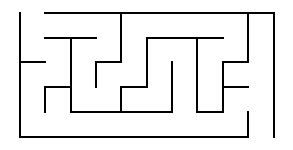

In [ ]:
M = random_maze(10, 5)
plot_maze(M, figsize=(5, 2.5))

# Solving Mazes

Now it is time to show how to solve a maze. I'll use breadth-first search, which guarantees that the solution will be the shortest possible (although for mazes with only one solution, the guarantee doesn't matter). The function `breadth_first_search` maintains a `frontier` of unexplored squares, and on each iteration removes a square from the frontier that is at the shallowest path depth, and adds to the frontier all the neighbors of that square that are not blocked by walls and have not been seen previously. The dictionary of `{square: [square,...]}` called `paths` has two purposes: it prevents us from creating loops in a path, and at the end it tells us the path from start to goal, e.g. `[(0, 0), (0, 1), (1, 1), (2, 1), ...]`.

In [ ]:
def breadth_first_search(maze):
    """Find a shortest sequence of states from start to the goal."""
    start = (0, 0)
    goal = (maze.width - 1, maze.height - 1)
    frontier = deque([start])  # A queue of states to consider
    paths = {start: [start]}   # start has a one-square path
    while frontier:
        s = frontier.popleft()
        if s == goal:
            return paths[s]
        for s2 in neighbors4(s):
            if s2 not in paths and edge(s, s2) in maze.edges:
                frontier.append(s2)
                paths[s2] = paths.get(s, []) + [s2]



In [ ]:
solution = breadth_first_search(M)
solution

[(0, 0),
 (0, 1),
 (1, 1),
 (1, 2),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 4),
 (2, 4),
 (3, 4),
 (4, 4),
 (5, 4),
 (6, 4),
 (7, 4),
 (8, 4),
 (8, 3),
 (9, 3),
 (9, 4)]

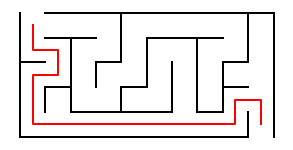

In [ ]:
plot_maze(M, figsize=(5, 2.5), path=solution)

# Strategies for the `pop` parameter of `random_maze`

Now I want to compare how the maze varies based on three different choices for the `pop` parameter.

# `pop=deque.pop`

The default pop method, `deque.pop`, means that the tree is created **depth-first**; we always select the `node` at the **end** of the `frontier`, so the tree follows a single branch along a randomly-twisted path until the path doubles back on itself and there are no more neighbors. At that point we select the most recent square for which there are neighbors and continue from there. The maze with `deque.pop` looks pretty good. Reminds me of those [cyber brain](https://www.vectorstock.com/royalty-free-vector/cyber-brain-vector-3071965) images. I'll `show` the maze without and then with the solution path.

In [ ]:
def show(pop):
    """Using this `pop` parameter, show a 70x70 maze, first without and then with the solution path."""
    M = random_maze(70, 70, pop)
    plot_maze(M)
    plt.show()
    solution = breadth_first_search(M)
    plot_maze(M, path=[(0, -1)] + solution + [(M.width - 1, M.height)])
    return len(solution)

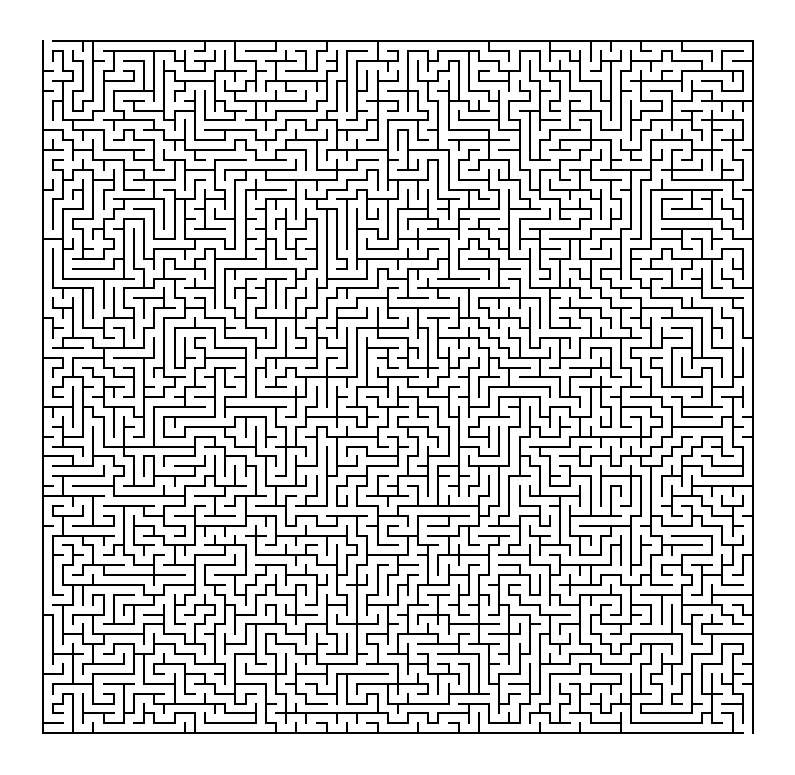

1307

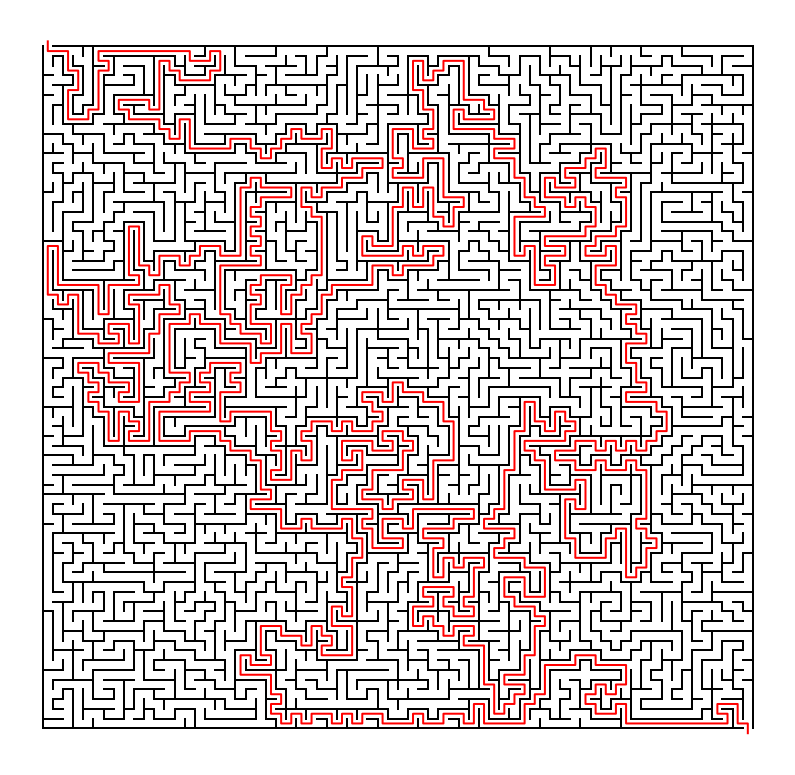

In [ ]:
show(deque.pop)

# `pop=deque.popleft`

This creates the maze roughly **breadth-first**&mdash;we start at some root square , add an edge to it, and from then on we always select first a parent edge before we select a child edge. The net result is a design that appears to radiate out in concentric layers from the root (which is chosen by `random_tree` and is not necessarily the top-left square; below it appears the root is in the lower-right quadrant). The `deque.popleft` maze is interesting as a design, but to me it doesn't work well as a maze. It is too easy to solve: follow the path from the start to the root, then consider the path from the end to the root, and see how they match up.

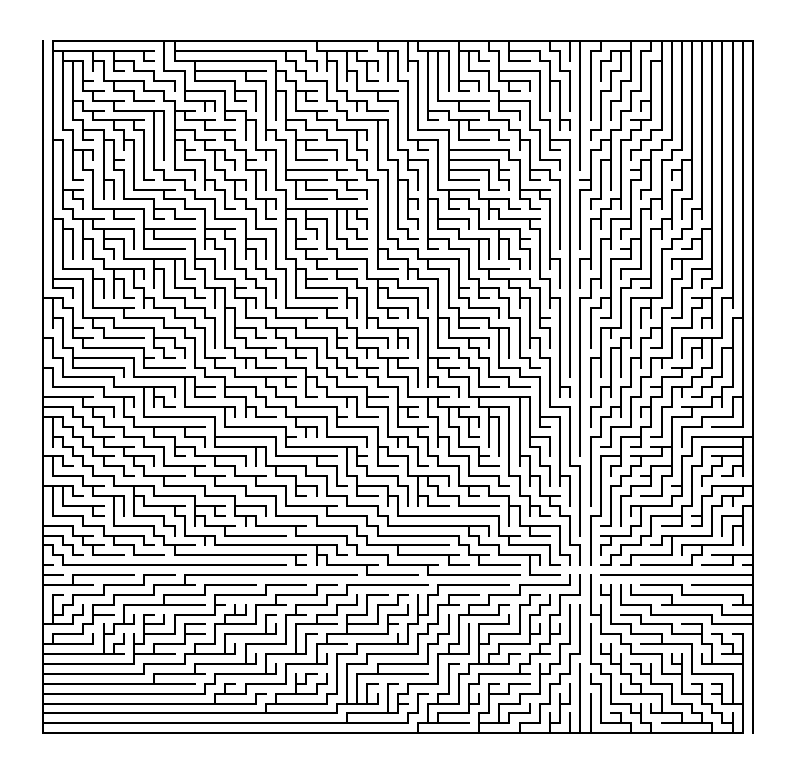

139

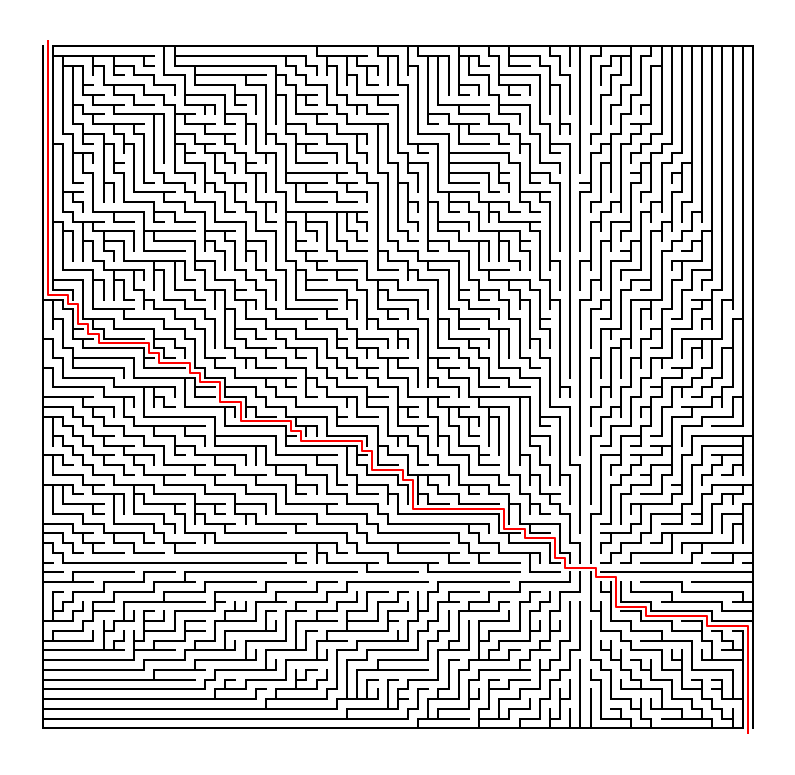

In [ ]:
show(deque.popleft)

# `pop=poprandom`

We can select a cell at random fromthe frontier.
This is an interesting compromise: it has some structure, and looks rather nice as a maze, in my opinion. However, I have to say that I was surprised that the path is almost as straight and short as in `pop=popleft`; not nearly as twisty as in `pop=deque.pop`.

In [ ]:
def poprandom(seq):
    """Select and return a random element; remove it from the sequence."""
    element = random.choice(seq)
    seq.remove(element)
    return element

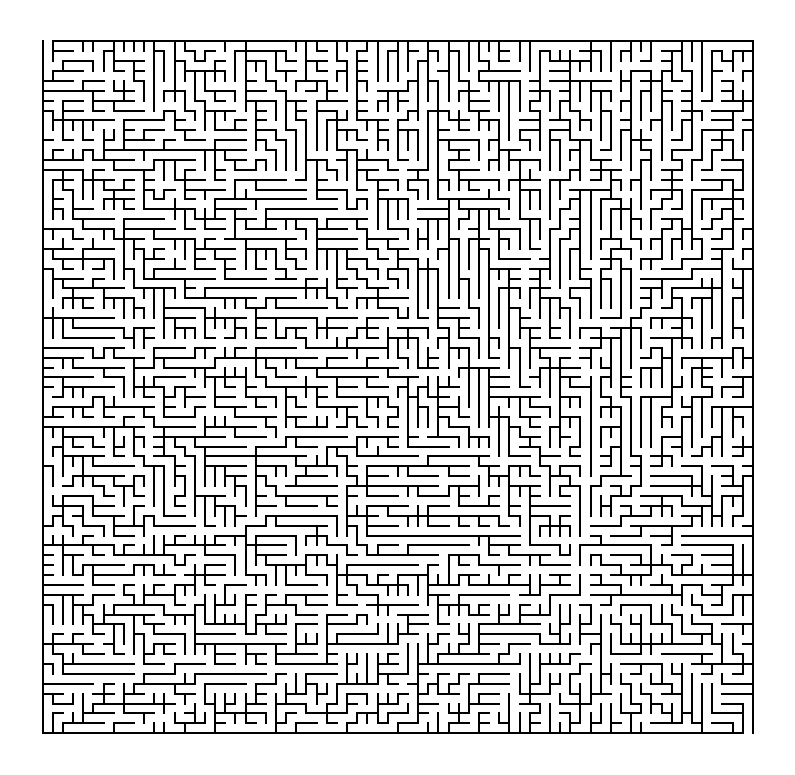

147

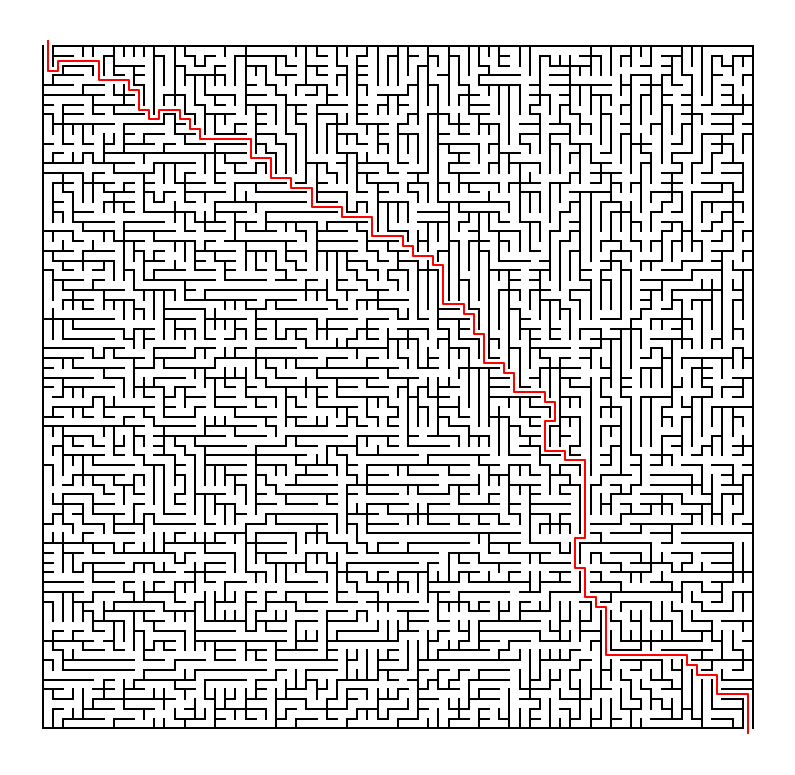

In [ ]:
show(poprandom)

What other variations can you come up with to generate interesting mazes?